In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mysql.connector


db = mysql.connector.connect(host = "your_host",
                            username = "your_username",
                            password = "your_password",
                            database = "your_database")

cur = db.cursor()

# List all unique cities where customers are located.

In [29]:
query = """select distinct customer_city from customers"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['customer_city'])
df.head()

,customer_city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [137]:
query = """select count(order_id) from orders where year(order_purchase_timestamp) = 2017"""

cur.execute(query)
data = cur.fetchall()

data[0][0]

45101

# Find the total sales per category.

In [33]:
query = """select pr.product_category, round(sum(pa.payment_value),2) as total_value
from products pr join order_items o on pr.product_id = o.product_id
join payments pa on o.order_id = pa.order_id
group by pr.product_category"""

cur.execute(query)
data =cur.fetchall()

df = pd.DataFrame(data, columns = ['product_category', 'total_value'])
df

,product_category,total_value
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,Fashion Bags and Accessories,218158.28
4,bed table bath,1712553.67
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


# Calculate the percentage of orders that were paid in installments.

In [36]:
query = """select (sum(case when payment_installments >= 1 then 1 else 0 end)) / count(*) * 100 as total_percentage_of_instalement from payments"""

cur.execute(query)
data = cur.fetchall()

data

[(Decimal('99.9981'),)]

# Count the number of customers from each state.

[]

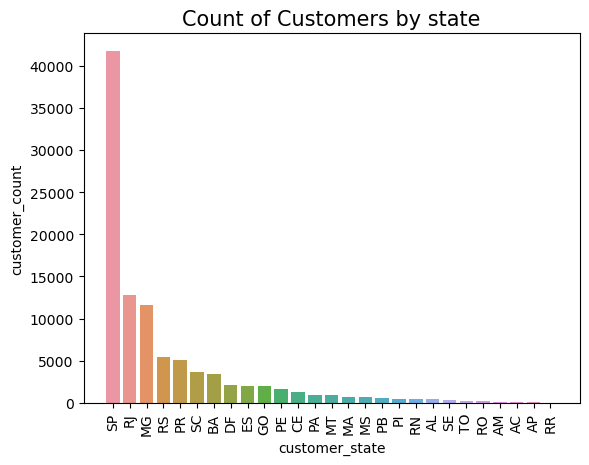

In [41]:
query = """select customer_state, count(distinct customer_id) AS customer_count from customers group by customer_state order by customer_count desc"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ['customer_state', 'customer_count'])
axes = sns.barplot(x='customer_state', y='customer_count', data =df)

axes.set_title('Count of Customers by state', fontsize=15)
plt.xticks(rotation='vertical')
plt.plot()

# Calculate the number of orders per month in 2018.

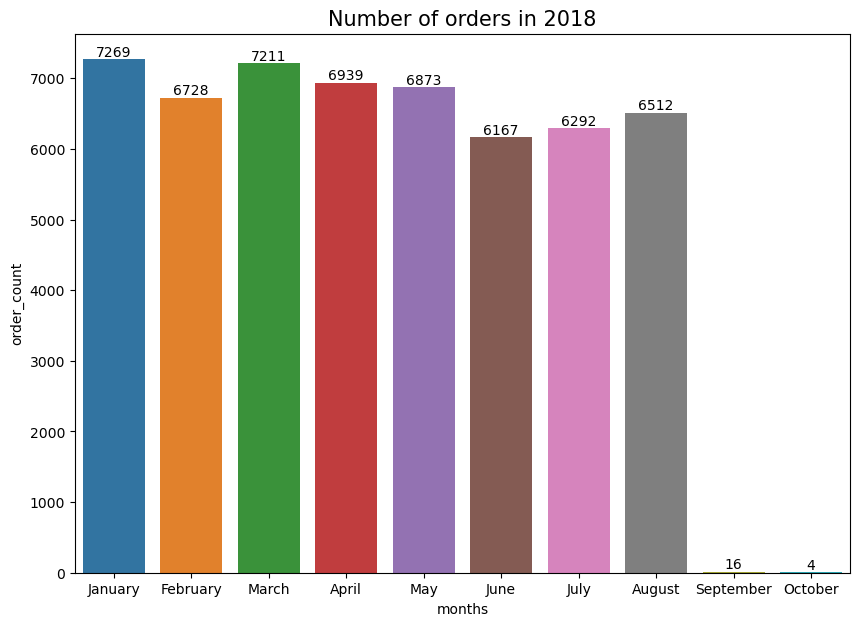

In [52]:
query = """select count(order_id) as order_count, monthname(order_purchase_timestamp) as months from orders where year(order_purchase_timestamp) = 2018
group by monthname(order_purchase_timestamp)"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ['order_count',  'months'])

month_orders= ["January", "February","March","April","May","June","July","August","September","October"]

plt.figure(figsize=(10,7))
ax = sns.barplot(y = 'order_count',  x ='months', data = df, order=month_orders)
ax.bar_label(ax.containers[0])
ax.set_title('Number of orders in 2018', fontsize=15)
plt.show()

# Find the average number of products per order, grouped by customer city.

In [97]:
query = """with count_per_order as (select o.order_id, o.customer_id, count(oi.order_id) as order_count from orders o join order_items oi 
on o.order_id = oi.order_id group by o.order_id, o.customer_id)
select c.customer_city, round(avg(co.order_count),2) as avg_per_order from count_per_order co join customers c 
on co.customer_id = c.customer_id group by c.customer_city order by avg_per_order desc"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ['customer_city', 'avg_per_order'])
df.head()

,customer_city,avg_per_order
0,padre carvalho,7.00
1,celso ramos,6.50
2,candido godoi,6.00
3,datas,6.00
4,matias olimpio,5.00


# Calculate the percentage of total revenue contributed by each product category.

In [63]:
query = """select p.product_category, round((sum(pa.payment_value)/(select sum(payment_value) from payments))*100,2) as percentage_of_revenue 
from products p join order_items oi on p.product_id = oi.product_id join payments pa on oi.order_id = pa.order_id
 group by p.product_category order by percentage_of_revenue desc"""

cur.execute(query)
data = cur.fetchall()

df= pd.DataFrame(data, columns = ['product_category', 'percentage_of_revenue'])
df.head()

,product_category,percentage_of_revenue
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93


# Identify the correlation between product price and the number of times a product has been purchased.

In [76]:
query = """select p.product_category, round(count(oi.product_id),2) as order_count, avg(oi.price) as avg_price from products p 
join order_items oi on p.product_id = oi.product_id group by p.product_category"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ['product_category', 'order_count', 'price'])

arry1 = df['order_count']
arry2 = df['price']

np.corrcoef([arry1,arry2])

array([[ 1.        , -0.10631552],
       [-0.10631552,  1.        ]])

# Calculate the total revenue generated by each seller, and rank them by revenue.

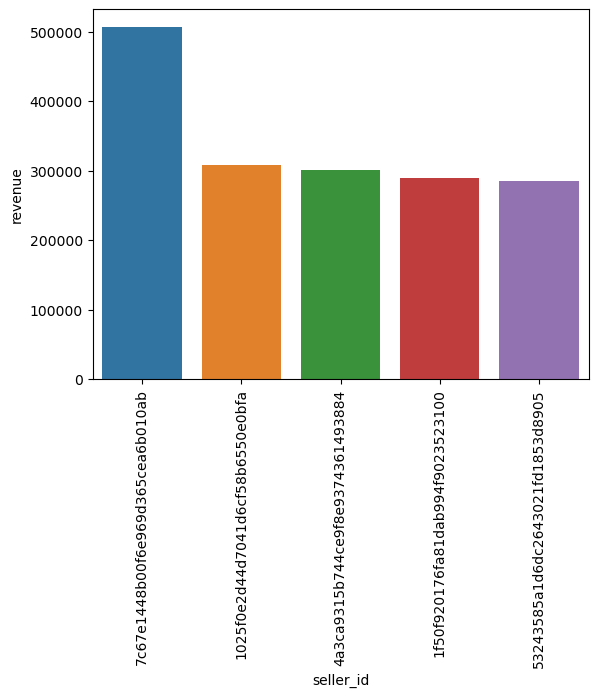

In [89]:
query = """select *, dense_rank() over(order by revenue desc) as ranking from (select o.seller_id, round(sum(p.payment_value),2) revenue
 from order_items o join payments p on p.order_id = o.order_id group by o.seller_id) as a"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ['seller_id', 'revenue', 'ranking'])
df = df.head()

sns.barplot(x = 'seller_id', y = 'revenue', data = df )
plt.xticks(rotation = 'vertical')
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [100]:
query = """select customer_id, order_purchase_timestamp, payment_value, avg(payment_value) over(partition by customer_id 
order by order_purchase_timestamp rows between 2 preceding and current row) as moving_average from
(select o.customer_id, o.order_purchase_timestamp, p.payment_value from orders o join payments p on p.order_id = o.order_id) as a"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ['customer_id', 'order_purchase_timestamp', 'payment_value', 'moving_average'])
df.head()

,customer_id,order_purchase_timestamp,payment_value,moving_average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002


# Calculate the cumulative sales per month for each year.

In [113]:
query = """select years, months, sales, sum(sales) over(order by years, months) as cumulative_sales from
(select year(order_purchase_timestamp) as years, month(o.order_purchase_timestamp) as months, round(sum(p.payment_value),2) as sales
from orders o join payments p on p.order_id = o.order_id group by years, months order by years, months) as a"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=['years', 'months', 'sales', 'cumulative_sales'])
df.head()

,years,months,sales,cumulative_sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39


# Calculate the year-over-year growth rate of total sales.

In [116]:
query = """with year_growth as (select year(o.order_purchase_timestamp) as years, sum(p.payment_value) as sales from orders o join payments p 
on p.order_id = o.order_id group by years) select years, (sales - lag(sales, 1) over(order by years))/lag(sales, 1) over(order by years) *100 
as yoy_growth_percentage from year_growth"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ['years', 'yoy_growth_percentage'])
df

,years,yoy_growth_percentage
0,2016,NaN
1,2017,12112.703760
2,2018,20.000924


# Identify the top 3 customers who spent the most money in each year.

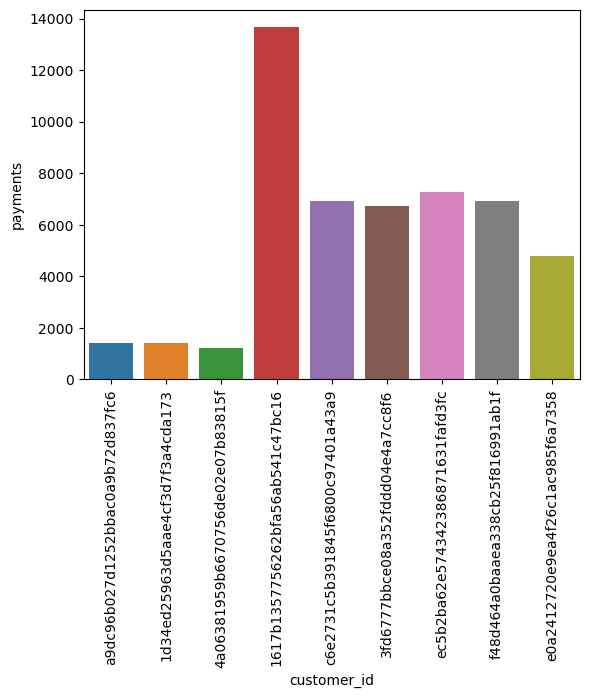

In [134]:
query = """select customer_id, years, payments, d_rank from
(select o.customer_id, year(o.order_purchase_timestamp) as years, sum(p.payment_value) as payments, dense_rank() over(partition by 
year(o.order_purchase_timestamp) order by sum(p.payment_value) desc) as d_rank from orders o join payments p on p.order_id = o.order_id 
group by 1, 2) as a where d_rank <= 3"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ['customer_id', 'years', 'payments', 'd_rank'])
sns.barplot(x= 'customer_id', y = 'payments', data = df)
plt.xticks(rotation = 90)
plt.show()